In [5]:
import numpy as np
import sympy as sp
from tqdm import tqdm

from kan import *  # Ensure that 'pykan' is installed or available in your PYTHONPATH

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
import torch
import torch.nn as nn
import torch.autograd as autograd


# Define a function that builds the gradient network in a differentiable manner
class GradNetwork(nn.Module):
    def __init__(self, base_network):
        super(GradNetwork, self).__init__()
        self.base_network = base_network

    def forward(self, x, idx=0):
        # Compute the output of the original network
        output = self.base_network(x)
        
        # Compute the gradient of the output with respect to input feature x[idx]
        grad_outputs = torch.ones_like(output)
        gradient = autograd.grad(
            outputs=output,
            inputs=x,
            grad_outputs=grad_outputs,
            create_graph=True,  # Important for allowing second-order gradients
            retain_graph=True  # Keep graph for further operations
        )[0]
        
        # Extract the gradient with respect to the specified dimension
        grad_i = gradient[:, idx].unsqueeze(1)  # Assuming batch size and extracting the i-th dimension
        
        return grad_i

# Instantiate the integral network as a simple KAN with 3 hidden neurons 
int_network = KAN(width=[2,3,1], grid=3, k=3, seed=1, device=device)

# Instantiate the gradient network
grad_network = GradNetwork(int_network)


checkpoint directory created: ./model
saving model version 0.0


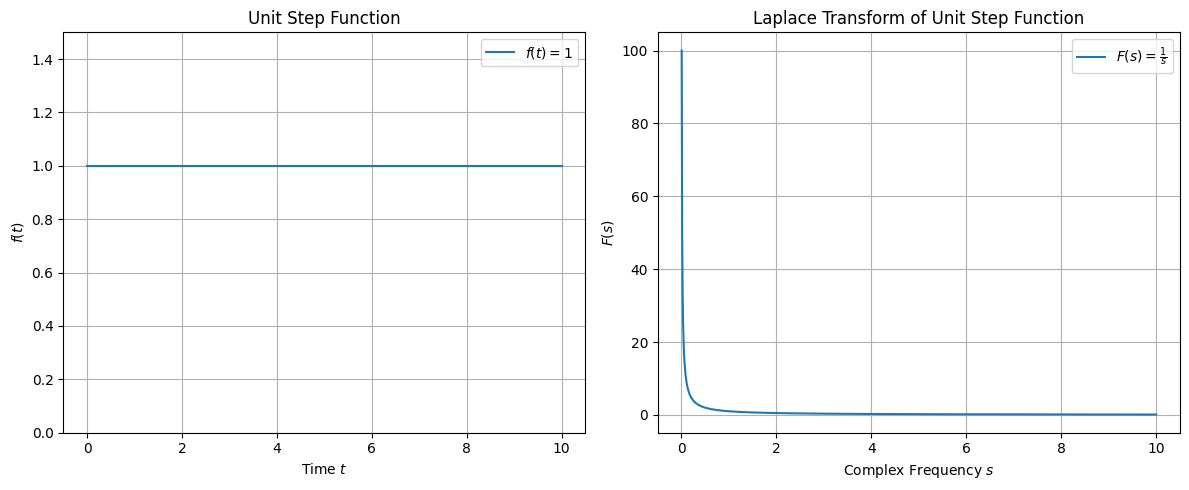

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Time domain (t ≥ 0)
t = np.linspace(0, 10, 1000)
f_t = np.ones_like(t)  # Unit step function

# Laplace domain (s > 0)
s = np.linspace(0.01, 10, 1000)  # Avoid s = 0
F_s = 1 / s

# Plotting the unit step function
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, f_t, label=r'$f(t) = 1$')
plt.title('Unit Step Function')
plt.xlabel('Time $t$')
plt.ylabel('$f(t)$')
plt.legend()
plt.ylim(0, 1.5)
plt.grid(True)

# Plotting the Laplace transform
plt.subplot(1, 2, 2)
plt.plot(s, F_s, label=r'$F(s) = \frac{1}{s}$')
plt.title('Laplace Transform of Unit Step Function')
plt.xlabel('Complex Frequency $s$')
plt.ylabel('$F(s)$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
# Define the true function we want to fit the gradient network to (this is the INTEGRAND)
def f(t):
    return np.exp(-t)

In [14]:
def integrand(x):
    t=x[:,0]
    s=x[:,1]
    
    return np.exp(-s*t)*f(t)

In [23]:
# Define the range for x and y
x_values = torch.linspace(0, 3, 100)
y_values = torch.linspace(0, 3, 100)

# Create a meshgrid
xx, yy = torch.meshgrid(x_values, y_values, indexing='ij')

# Flatten the grid and stack to get input pairs (x, y)
inputs = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # Shape: [10000, 2]

# Compute the true gradients at each (x, y)
true_grad = integrand(inputs)  # Shape: [10000, 2]



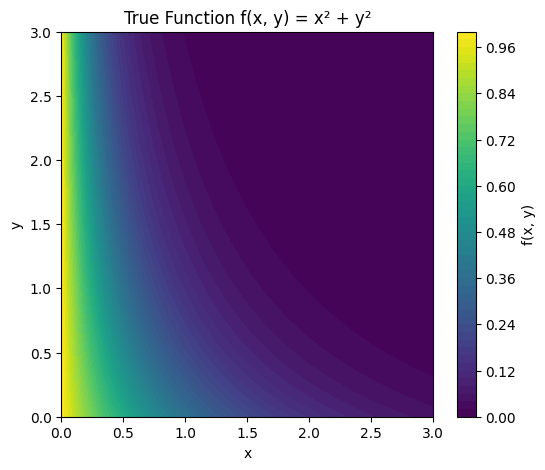

In [24]:
# Plot the true function
Z = integrand(inputs).reshape(100, 100).detach().numpy()

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, levels=50, cmap='viridis')
plt.colorbar(label='f(x, y)')
plt.title('True Function f(x, y) = x² + y²')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [ ]:
    x_train.requires_grad_(True)

In [26]:
import torch.optim as optim



# Set up the optimizer and loss function
optimizer = optim.Adam(grad_network.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Number of training epochs
n_epochs = 1000

# For tracking loss over epochs
loss_history = []

for epoch in range(n_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    inputs.requires_grad_(True)
    # Forward pass through the network
    grad_output = grad_network(inputs)  # Shape: [10000, 2]
    
    # Compute the loss between predicted gradients and true gradients
    loss = criterion(grad_output, true_grad)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Update network parameters
    optimizer.step()
    
    # Record the loss
    loss_history.append(loss.item())
    
    # Print loss occasionally
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')



/Users/justinas/.pyenv/versions/3.9.19/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Loss: 0.057114
Epoch [200/1000], Loss: 0.057100
Epoch [300/1000], Loss: 0.057098
Epoch [400/1000], Loss: 0.057096
Epoch [500/1000], Loss: 0.057095
Epoch [600/1000], Loss: 0.057095


KeyboardInterrupt: 

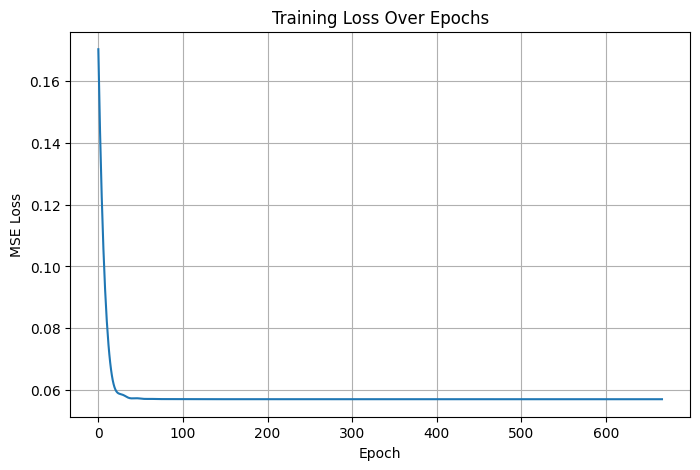

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


In [28]:
with torch.no_grad():
    predicted_grad = grad_network(inputs)  # Shape: [10000, 2]

# Reshape for plotting
df_dx_true = true_grad[:, 0].reshape(100, 100).numpy()
df_dy_true = true_grad[:, 1].reshape(100, 100).numpy()

df_dx_pred = predicted_grad[:, 0].reshape(100, 100).numpy()
df_dy_pred = predicted_grad[:, 1].reshape(100, 100).numpy()

# Plot true gradient field
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.quiver(xx, yy, df_dx_true, df_dy_true, color='r', alpha=0.5)
plt.title('True Gradient Field')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Plot predicted gradient field
plt.subplot(1, 2, 2)
plt.quiver(xx, yy, df_dx_pred, df_dy_pred, color='b', alpha=0.5)
plt.title('Predicted Gradient Field')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.show()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn